
# Clasificación de Niveles de Obesidad — Pipeline completo
**Descripción:** Notebook que carga `dataset_limpio.csv` (Generado en notebook EDA), realiza preprocesamiento, entrena y compara **RandomForest** y **XGBoost**, ajusta hiperparámetros, evalúa modelos y guarda el mejor pipeline.  


In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import joblib
import matplotlib.pyplot as plt

print('Librerías cargadas correctamente.')


Librerías cargadas correctamente.


In [121]:
path = 'dataset_limpio.csv'
df = pd.read_csv(path)


print('Dimensiones:', df.shape)
display(df.head())


Dimensiones: (2153, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,normal_weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,normal_weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,normal_weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,overweight_level_i
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,overweight_level_ii


In [122]:
# Inspección rápida
print(df.info())
print('\nDistribución por columnas:\n', df.describe(include='all').T)

# Detectar columna objetivo
target_col = 'NObeyesdad' if 'NObeyesdad' in df.columns else df.columns[-1]
print('\nColumna objetivo asumida:', target_col)

# Codificar target
if df[target_col].dtype == 'object' or str(df[target_col].dtype).startswith('category'):
    # Convertir a tipo category y obtener los nombres de las categorías
    df[target_col] = df[target_col].astype('category')
    clases_reales = df[target_col].cat.categories
    # Convertir a códigos numéricos para el entrenamiento
    df[target_col] = df[target_col].astype('category').cat.codes
    print('Objetivo codificado. Clases:', df[target_col].unique())
    print('Nombres de Clases (clases_reales):', clases_reales.tolist())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2153 non-null   object 
 1   Age                             2153 non-null   float64
 2   Height                          2153 non-null   float64
 3   Weight                          2153 non-null   float64
 4   family_history_with_overweight  2153 non-null   object 
 5   FAVC                            2153 non-null   object 
 6   FCVC                            2153 non-null   float64
 7   NCP                             2153 non-null   float64
 8   CAEC                            2153 non-null   object 
 9   SMOKE                           2153 non-null   object 
 10  CH2O                            2153 non-null   float64
 11  SCC                             2153 non-null   object 
 12  FAF                             21

In [123]:
# Feature engineering: crear IMC (BMI)
if set(['Height','Weight']).issubset(df.columns):
    df['BMI'] = df['Weight'] / ((df['Height']/100)**2)
    print('Se creó la variable BMI.')
else:
    print('Height/Weight no encontrados; saltando creación de BMI.')

display(df.head())


Se creó la variable BMI.


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,1,243865.264441
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,1,242382.271468
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,1,237654.320988
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,5,268518.518519
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,6,283423.810125


In [124]:
# Preparar X,y & preprocesamiento
mapping_names = {i: f"{i}-{name}" for i, name in enumerate(clases_reales)}
X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print('Numéricas:', num_cols)
print('Categóricas:', cat_cols)

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preproc = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)], remainder='drop')


Numéricas: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
Categóricas: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [125]:
# División train/test estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train:', X_train.shape, 'Test:', X_test.shape)
print('\nDistribución (train):\n', pd.Series(y_train).map(mapping_names).value_counts(normalize=True))


Train: (1722, 17) Test: (431, 17)

Distribución (train):
 NObeyesdad
2-obesity_type_i         0.174216
4-obesity_type_iii       0.151568
3-obesity_type_ii        0.140534
5-overweight_level_i     0.137631
6-overweight_level_ii    0.135889
1-normal_weight          0.133566
0-insufficient_weight    0.126597
Name: proportion, dtype: float64


In [126]:
# RandomForest baseline
target_names_format = [f"{i}-{name}" for i, name in enumerate(clases_reales)]
rf_pipe = Pipeline([('pre', preproc),
                    ('clf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'))])

rf_pipe.fit(X_train, y_train)
pred_rf = rf_pipe.predict(X_test)
print('RandomForest - Accuracy:', accuracy_score(y_test, pred_rf))
print()
print(classification_report(y_test, pred_rf, target_names=target_names_format))
print()
print('Confusion matrix:\n', confusion_matrix(y_test, pred_rf))


RandomForest - Accuracy: 0.9582366589327146

                       precision    recall  f1-score   support

0-insufficient_weight       0.98      0.98      0.98        54
      1-normal_weight       0.90      0.98      0.94        58
     2-obesity_type_i       0.96      0.91      0.93        75
    3-obesity_type_ii       0.98      0.97      0.98        61
   4-obesity_type_iii       0.97      0.97      0.97        65
 5-overweight_level_i       0.97      0.97      0.97        60
6-overweight_level_ii       0.95      0.95      0.95        58

             accuracy                           0.96       431
            macro avg       0.96      0.96      0.96       431
         weighted avg       0.96      0.96      0.96       431


Confusion matrix:
 [[53  1  0  0  0  0  0]
 [ 1 57  0  0  0  0  0]
 [ 0  2 68  0  1  1  3]
 [ 0  1  0 59  1  0  0]
 [ 0  0  1  1 63  0  0]
 [ 0  1  1  0  0 58  0]
 [ 0  1  1  0  0  1 55]]


In [144]:
# XGBoost con SMOTE y RandomizedSearchCV
#num_classes = len(np.unique(y))
xgb_pipe_smote = ImbPipeline([('pre', preproc),
                        ('smote', SMOTE(random_state=42)),
                        ('clf', XGBClassifier(objective='multi:softprob',
                                              #use_label_encoder=False,
                                              eval_metric='mlogloss',
                                              random_state=42))#,
                                              #num_class=num_classes))
                        ])

param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'smote__k_neighbors': [1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(xgb_pipe_smote,
                            param_dist,
                            n_iter=20,
                            scoring='accuracy',
                            n_jobs=-1,
                            cv=cv,
                            random_state=42,
                            verbose=2)
print('Iniciando búsqueda aleatoria XGBoost.\n')

search.fit(X_train, y_train)
best_xgb = search.best_estimator_
pred_xgb = best_xgb.predict(X_test)
print('\nMejores parámetros:', search.best_params_)
print('\nXGBoost - Accuracy:', accuracy_score(y_test, pred_xgb))
print()
print(classification_report(y_test, pred_xgb, target_names=target_names_format))
print()
print('Confusion matrix:\n', confusion_matrix(y_test, pred_xgb))


Iniciando búsqueda aleatoria XGBoost.

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores parámetros: {'smote__k_neighbors': 1, 'clf__subsample': 0.6, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.6}

XGBoost - Accuracy: 0.9698375870069605

                       precision    recall  f1-score   support

0-insufficient_weight       0.98      0.98      0.98        54
      1-normal_weight       0.95      0.98      0.97        58
     2-obesity_type_i       0.97      0.92      0.95        75
    3-obesity_type_ii       0.98      0.97      0.98        61
   4-obesity_type_iii       0.97      0.98      0.98        65
 5-overweight_level_i       0.97      0.98      0.98        60
6-overweight_level_ii       0.97      0.98      0.97        58

             accuracy                           0.97       431
            macro avg       0.97      0.97      0.97       431
         weighted avg       0.97      0.97      0.97

In [153]:
#XGBoost sin SMOTE
#Extraer los mejores parámetros de XGBoost de la búsqueda anterior
best_params_xgb = {
    k.replace('clf__', ''): v
    for k, v in search.best_params_.items()
    if k.startswith('clf__') and 'k_neighbors' not in k
}

#Entrenar el pipeline sin SMOTE
xgb_simple_pipe = Pipeline(steps=[
    ('pre', preproc),
    ('clf', XGBClassifier(
        **best_params_xgb, # Apply the learned parameters
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42             # Ensure reproducibility
    ))
])


xgb_simple_pipe.fit(X_train, y_train)


# Evaluar el modelo sin SMOTE
pred_xgb_simple = xgb_simple_pipe.predict(X_test)

# 5. Mostrar resultados
print('XGBoost sin SMOTE - Accuracy:', accuracy_score(y_test, pred_xgb_simple))
print()
print(classification_report(y_test, pred_xgb_simple, target_names=target_names_format))
print()
print('Matriz de Confusión:\n', confusion_matrix(y_test, pred_xgb_simple))


XGBoost sin SMOTE - Accuracy: 0.9721577726218097

                       precision    recall  f1-score   support

0-insufficient_weight       0.98      1.00      0.99        54
      1-normal_weight       0.98      0.98      0.98        58
     2-obesity_type_i       0.96      0.92      0.94        75
    3-obesity_type_ii       0.98      0.97      0.98        61
   4-obesity_type_iii       0.97      0.98      0.98        65
 5-overweight_level_i       0.97      0.98      0.98        60
6-overweight_level_ii       0.97      0.98      0.97        58

             accuracy                           0.97       431
            macro avg       0.97      0.97      0.97       431
         weighted avg       0.97      0.97      0.97       431


Matriz de Confusión:
 [[54  0  0  0  0  0  0]
 [ 1 57  0  0  0  0  0]
 [ 0  1 69  0  1  2  2]
 [ 0  0  1 59  1  0  0]
 [ 0  0  0  1 64  0  0]
 [ 0  0  1  0  0 59  0]
 [ 0  0  1  0  0  0 57]]


In [154]:
# Comparar y guardar
acc_rf = accuracy_score(y_test, pred_rf)
acc_xgb = accuracy_score(y_test, pred_xgb)
acc_xgb_simple = accuracy_score(y_test, pred_xgb_simple)
if acc_xgb >= acc_rf:
    best_model = best_xgb
    best_name = 'XGBoost'
    best_acc = acc_xgb
else:
    best_model = rf_pipe
    best_name = 'RandomForest'
    best_acc = acc_rf
if acc_xgb_simple > best_acc:
    best_model = acc_xgb_simple
    best_name = 'XGBoost (sin SMOTE)'
    best_acc = acc_xgb_simple

print('Mejor modelo:', best_name, 'Accuracy:', best_acc)
joblib.dump(best_model, 'best_pipeline.joblib')
print('Pipeline guardado en best_pipeline.joblib')


Mejor modelo: XGBoost (sin SMOTE) Accuracy: 0.9721577726218097
Pipeline guardado en best_pipeline.joblib


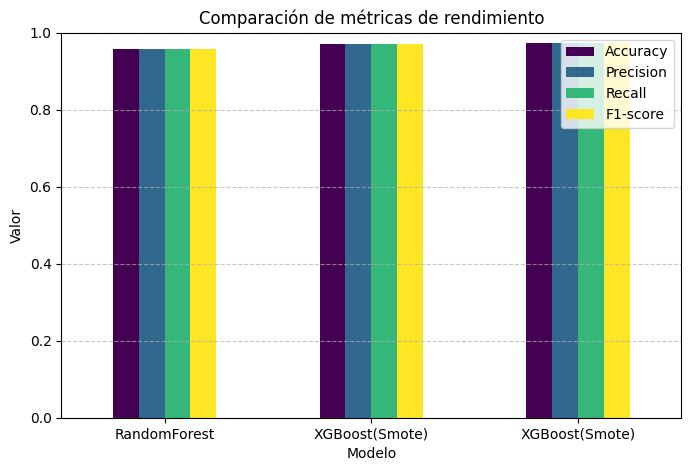

,Modelo,Accuracy,Precision,Recall,F1-score
0,RandomForest,0.958237,0.958911,0.958237,0.958226
1,XGBoost(Smote),0.969838,0.969995,0.969838,0.969718
2,XGBoost(Smote),0.972158,0.972096,0.972158,0.972012


In [155]:
# Crear DataFrame de métricas comparativas
metrics_df = pd.DataFrame({
    'Modelo': ['RandomForest', 'XGBoost(Smote)', 'XGBoost(Smote)'],
    'Accuracy': [accuracy_score(y_test, pred_rf),
                 accuracy_score(y_test, pred_xgb),
                 accuracy_score(y_test, pred_xgb_simple)],
    'Precision': [precision_score(y_test, pred_rf, average='weighted'),
                  precision_score(y_test, pred_xgb, average='weighted'),
                  precision_score(y_test, pred_xgb_simple, average='weighted')],
    'Recall': [recall_score(y_test, pred_rf, average='weighted'),
               recall_score(y_test, pred_xgb, average='weighted'),
               recall_score(y_test, pred_xgb_simple, average='weighted')],
    'F1-score': [f1_score(y_test, pred_rf, average='weighted'),
                 f1_score(y_test, pred_xgb, average='weighted'),
                 f1_score(y_test, pred_xgb_simple, average='weighted')]
})

# Gráfico de barras comparativo
plt.figure(figsize=(8,5))
metrics_df.set_index('Modelo').plot(kind='bar', ax=plt.gca(), colormap='viridis')
plt.title('Comparación de métricas de rendimiento')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

display(metrics_df)

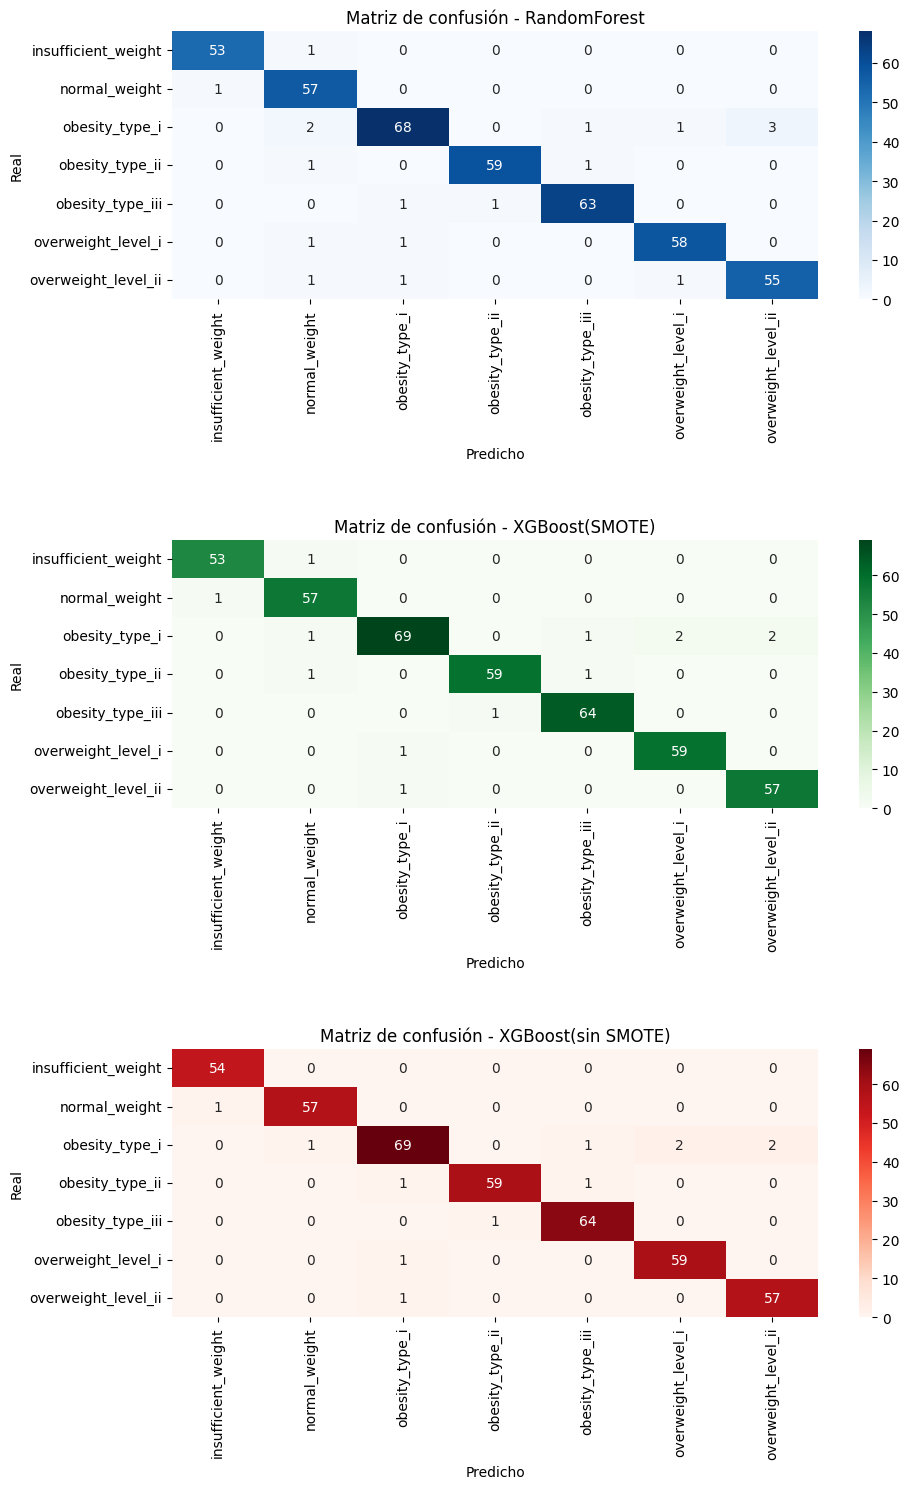

In [160]:
# Matrices de confusión
fig, axes = plt.subplots(3, 1, figsize=(10,15))

sns.heatmap(confusion_matrix(y_test, pred_rf),
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=axes[0],
            xticklabels=clases_reales,
            yticklabels=clases_reales)
axes[0].set_title('Matriz de confusión - RandomForest')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

sns.heatmap(confusion_matrix(y_test, pred_xgb),
            annot=True, fmt='d',
            cmap='Greens',
            ax=axes[1],
            xticklabels=clases_reales,
            yticklabels=clases_reales)
axes[1].set_title('\n\nMatriz de confusión - XGBoost(SMOTE)')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

sns.heatmap(confusion_matrix(y_test, pred_xgb_simple),
            annot=True, fmt='d',
            cmap='Reds',
            ax=axes[2],
            xticklabels=clases_reales,
            yticklabels=clases_reales)
axes[2].set_title('\n\nMatriz de confusión - XGBoost(sin SMOTE)')
axes[2].set_xlabel('Predicho')
axes[2].set_ylabel('Real')

plt.tight_layout()
plt.show()

In [161]:
# Evaluar overfitting / underfitting
def evaluar_overfitting(modelo, X_train, X_test, y_train, y_test, nombre):
    train_score = modelo.score(X_train, y_train)
    test_score = modelo.score(X_test, y_test)
    gap = train_score - test_score
    print(f'\nModelo: {nombre}')
    print(f'  Score en entrenamiento: {train_score:.3f}')
    print(f'  Score en prueba:        {test_score:.3f}')
    print(f'  Diferencia (gap):       {gap:.3f}')
    if gap > 0.1:
        print("Posible sobreajuste (overfitting).")
    elif gap < -0.05:
        print("Posible bajoajuste (underfitting).")
    else:
        print("Ajuste adecuado (sin evidencia fuerte de over/underfitting).")

evaluar_overfitting(rf_pipe, X_train, X_test, y_train, y_test, "RandomForest")
evaluar_overfitting(best_xgb, X_train, X_test, y_train, y_test, "XGBoost (SMOTE)")
evaluar_overfitting(xgb_simple_pipe, X_train, X_test, y_train, y_test, "XGBoost (sin SMOTE)")


Modelo: RandomForest
  Score en entrenamiento: 0.992
  Score en prueba:        0.958
  Diferencia (gap):       0.034
Ajuste adecuado (sin evidencia fuerte de over/underfitting).

Modelo: XGBoost (SMOTE)
  Score en entrenamiento: 0.999
  Score en prueba:        0.970
  Diferencia (gap):       0.030
Ajuste adecuado (sin evidencia fuerte de over/underfitting).

Modelo: XGBoost (sin SMOTE)
  Score en entrenamiento: 0.999
  Score en prueba:        0.972
  Diferencia (gap):       0.027
Ajuste adecuado (sin evidencia fuerte de over/underfitting).


In [167]:
def graficar_learning_curve_robusta(modelo, X, y, titulo):

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    train_sizes, train_scores, test_scores = learning_curve(
        modelo, X, y,
        cv=10,
        scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1,
        error_score=np.nan
    )

    train_mean = np.nanmean(train_scores, axis=1)
    test_mean = np.nanmean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento')
    plt.plot(train_sizes, test_mean, 's--', label='Validación')
    plt.title(f'Curva de aprendizaje - {titulo}')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def curva_entrenamiento_val(modelo, X, y, titulo):
    train_sizes = np.linspace(0.1, 0.99, 8)
    train_scores, val_scores = [], []

    for frac in train_sizes:
        X_train_sub, _, y_train_sub, _ = train_test_split(X, y, train_size=frac, stratify=y, random_state=42)
        modelo.fit(X_train_sub, y_train_sub)
        y_pred_train = modelo.predict(X_train_sub)
        y_pred_val = modelo.predict(X)
        train_scores.append(accuracy_score(y_train_sub, y_pred_train))
        val_scores.append(accuracy_score(y, y_pred_val))

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores, 'o-', label='Entrenamiento')
    plt.plot(train_sizes, val_scores, 's--', label='Validación')
    plt.title(f'Curva entrenamiento vs validación - {titulo}')
    plt.xlabel('Proporción de entrenamiento')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

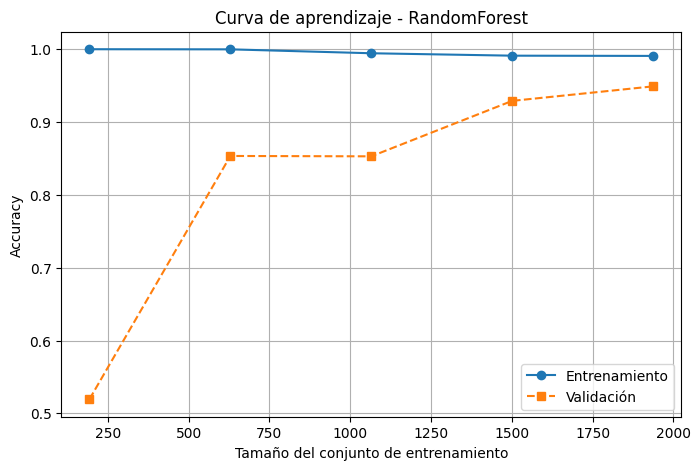

In [168]:
# RandomForest
graficar_learning_curve_robusta(rf_pipe, X, y, 'RandomForest')

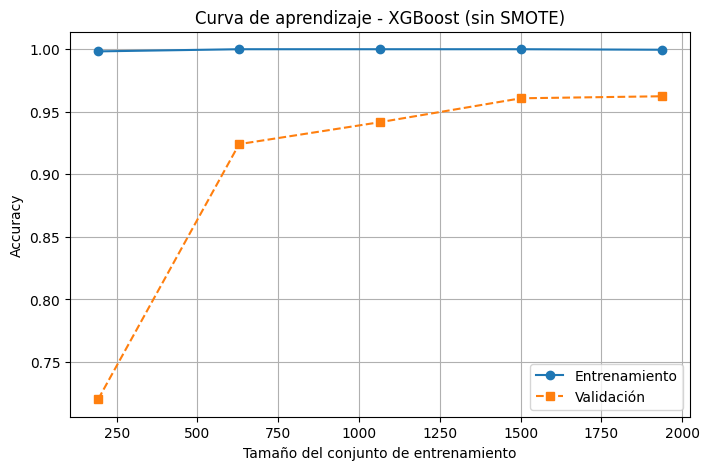

In [170]:
# XGBoost (sinSMOTE)

graficar_learning_curve_robusta(xgb_simple_pipe, X, y, 'XGBoost (sin SMOTE)')

# Curva de aprendizage XGBoots SMOTE

### Explicación: Por qué Falló la Curva de Aprendizaje de XGBoost con SMOTE

La curva de aprendizaje para el modelo **XGBoost con SMOTE** falló debido a un conflicto entre la función `learning_curve` de Scikit-learn y la naturaleza del algoritmo de sobremuestreo SMOTE cuando se aplica dentro de un *pipeline*.

El problema principal ocurre en las **primeras iteraciones** de la curva de aprendizaje, cuando el tamaño del conjunto de entrenamiento es muy pequeño (ej., 10% de los datos).

---

### El Proceso de `learning_curve` y el Conflicto

La función `learning_curve` divide repetidamente el conjunto de datos de entrenamiento en subconjuntos cada vez más grandes. En cada iteración:

1.  **Toma un subconjunto incremental de datos de entrenamiento** (ej., 100 muestras).
2.  **Aplica el *pipeline* completo** (Preprocesamiento $\rightarrow$ **SMOTE** $\rightarrow$ XGBoost) a esas 100 muestras.

### El Error de Muestras Insuficientes para SMOTE

Cuando el subconjunto de entrenamiento inicial es muy pequeño, es muy probable que la **clase minoritaria** tenga un número extremadamente bajo de muestras.

SMOTE requiere poder encontrar vecinos cercanos para crear nuevas muestras sintéticas. Si se usa la configuración por defecto o una configuración común como $k=5$ (5 vecinos más cercanos), SMOTE necesita al menos $k+1$ muestras de la clase minoritaria para poder operar.

* Si el subconjunto de entrenamiento solo tiene $\leq 5$ muestras de la clase minoritaria, **SMOTE falla** con un `ValueError` (o similar), ya que no puede encontrar los $k=5$ vecinos necesarios.
* Alternativamente, el subconjunto pequeño puede resultar en un *split* donde solo existe **una única clase** (ej., solo la clase '1' y ninguna clase '0'), lo que provoca el error que viste anteriormente: `ValueError: Invalid classes inferred... Expected: [0], got [1]`.

Dado que `learning_curve` no puede completar la evaluación para esos tamaños pequeños, la ejecución se detiene o lanza una excepción.


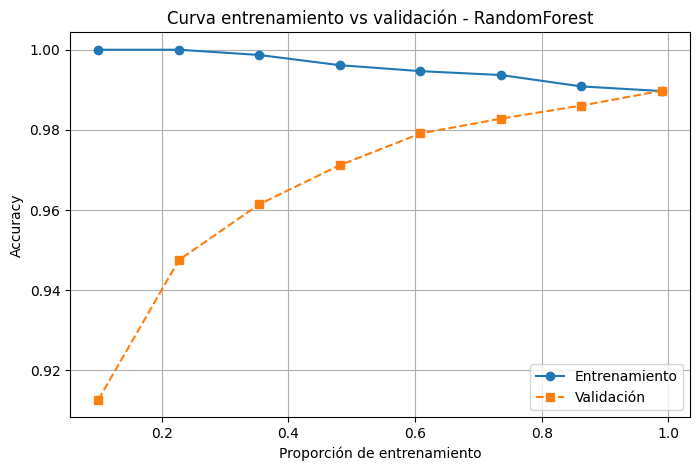

In [173]:
curva_entrenamiento_val(rf_pipe, X, y, 'RandomForest')

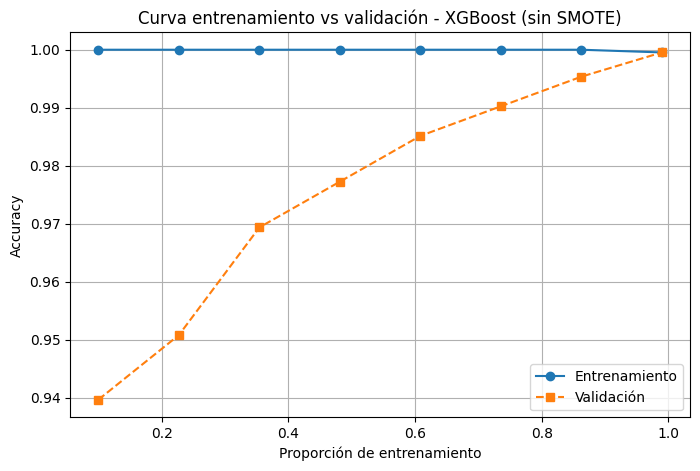

In [174]:
curva_entrenamiento_val(xgb_simple_pipe, X, y, 'XGBoost (sin SMOTE)')

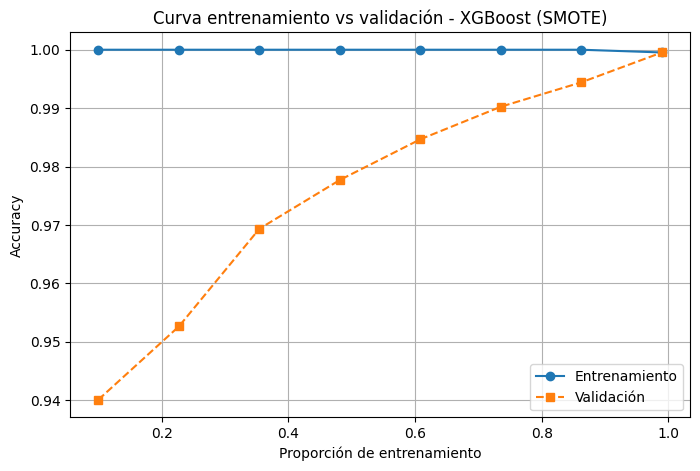

In [169]:
curva_entrenamiento_val(best_xgb, X, y, 'XGBoost (SMOTE)')